In [1]:
import mediapipe as mp
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_drawing_styles = mp.solutions.drawing_styles

In [3]:
sample_img = cv2.imread('img_repository/img01.jpeg')

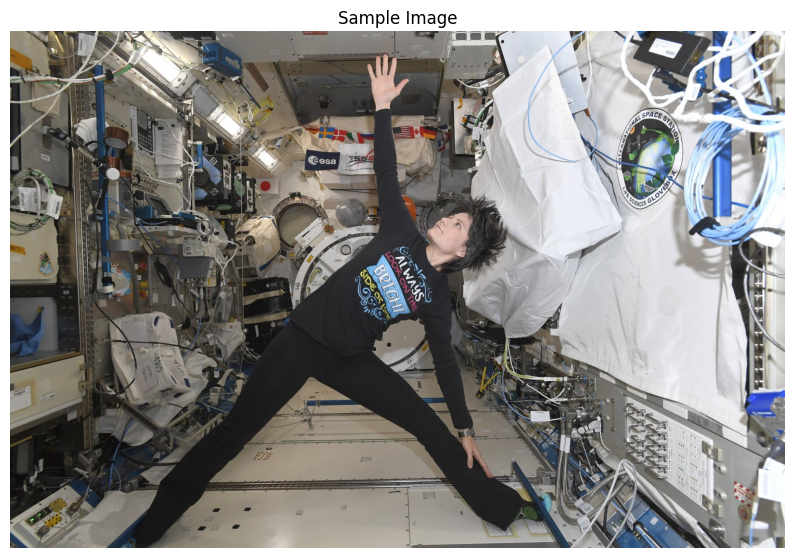

In [4]:
plt.figure(figsize= [10,10])
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

I0000 00:00:1728236346.850813 6934798 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1728236346.956998 6935090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728236346.973190 6935093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728236346.989590 6935095 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/fabioluisbuitragoochoa/Documents/Projects/AstroYoga/envNASA/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase

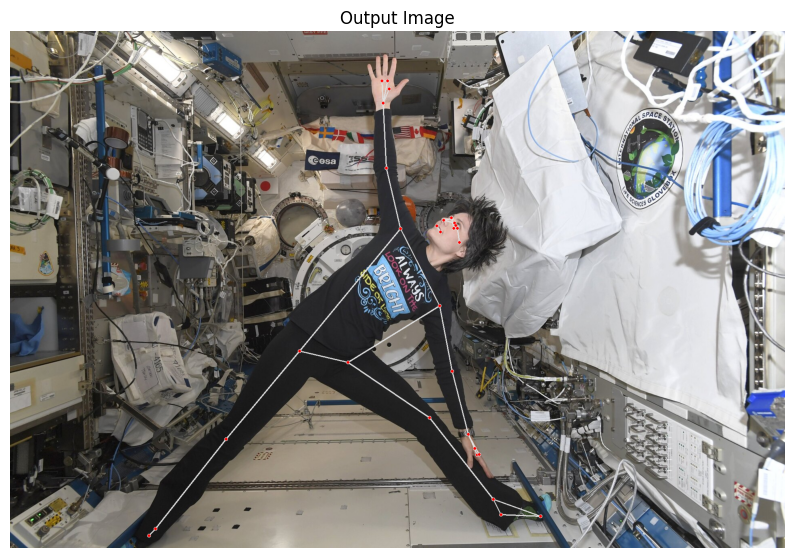

In [5]:
img_copy = sample_img.copy()
pose = mp_pose.Pose(static_image_mode=True)
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    fig = plt.figure(figsize= [10,10])
    plt.title("Output Image");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()


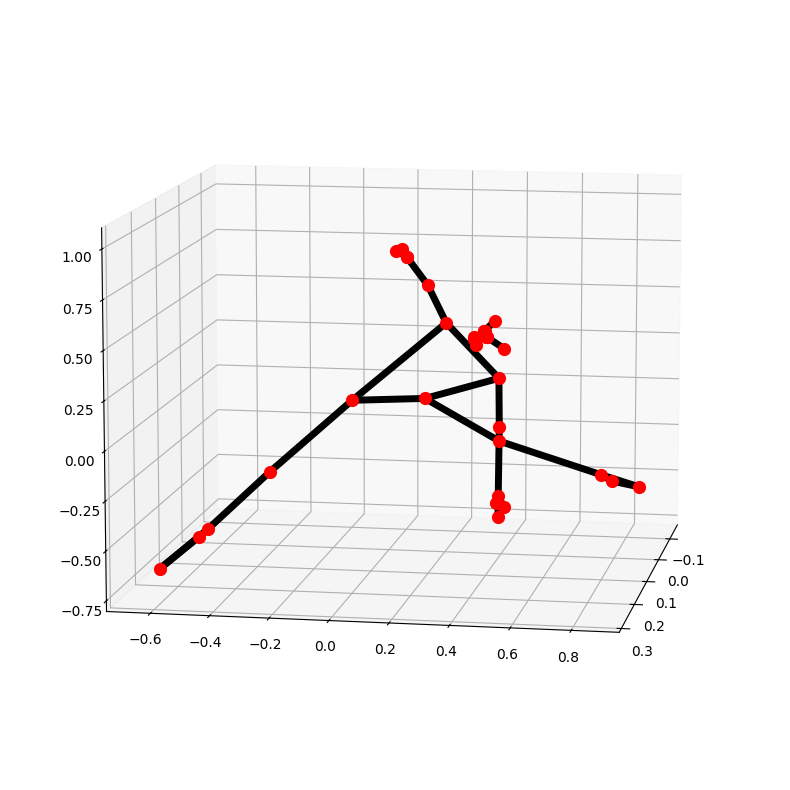

In [6]:
# Plot pose landmark in 3D
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

## Detect pose

In [7]:
def detectPose(image, pose, display = True):
    output_image = image.copy()
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(imageRGB)
    height, width, _ = image.shape
    landmarks = []

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((int(landmark.x * width), int(landmark.y * height),(landmark.z * width)))
    return output_image, landmarks

## Pose Classification with Angle Heuristics

In [8]:
def calculateAngle(landmark1, landmark2, landmark3):
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))

    if angle < 0:
        angle += 360
    
    return angle

In [9]:
def classifyPose(landmarks, output_image, display = False):

    label = 'Unknown Pose'

    color = (0,0, 255)

    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value])
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    # Check if the both arms are straight.
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:
        # Check if shoulders are at the required angle.
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:

    # Check if it is the warrior pose.

            # Check if one leg is straight.
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
                # Check if the other leg is bended at the required angle.
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:
                    # Specify the label of the pose that is warrior pose.
                    label = 'Warrior Pose'

    # Check if it is the T pose.

            # Check if both legs are straight.
            if left_knee_angle > 160 and left_knee_angle < 195 or right_knee_angle > 160 and right_knee_angle < 195:
                # Specify the label of the pose that is T pose.
                label = 'T Pose'

    # Check if it is tree pose.
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:
            # Specify the label of the pose that is T pose.
            label = 'Tree Pose'
    
    if label != 'Unknown Pose':
        color = (0,255,0)

    cv2.putText(output_image, label, (10, 30), cv2. FONT_HERSHEY_PLAIN, 2, color, 2)

    if display:
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
        plt.figure(figsize= [10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output image");plt.axis('off')
    else:
        return output_image, label


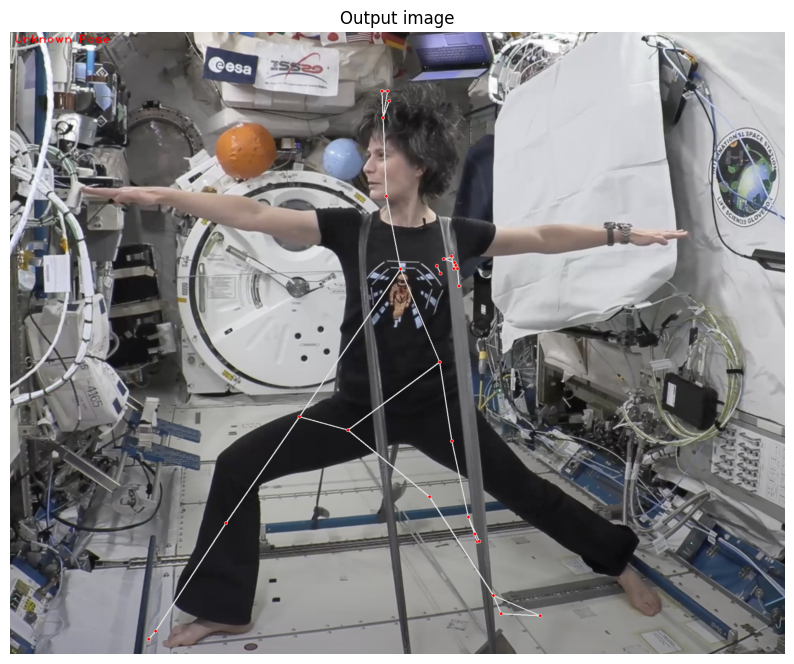

In [11]:
image_2 = cv2.imread('img_repository/img02_warrior_pose.png')

output_image_2, landmarks = detectPose(image_2, pose, display = False)

if landmarks:
    classifyPose(landmarks, output_image_2, display = True)


In [10]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_drawing_styles = mp.solutions.drawing_styles

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    # Draw the pose annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()

I0000 00:00:1728245849.484854 6934798 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1728245849.619112 6987579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728245849.632460 6987574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
2024-10-06 15:17:29.950 Python[68152:6934798] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


KeyboardInterrupt: 